# Hugging Face Library 'Transformer'およびT5Tokenizerのダウンロード

参考(https://qiita.com/takubb/items/fd972f0ac3dba909c293)これを基に改造し、最新のGoogle Colaboratoryで動作するようにした

In [1]:
!pip install transformers
!apt install swig
# Sentencepieceのインストール
!pip install sentencepiece
from transformers import T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained("rinna/japanese-roberta-base")
tokenizer.do_lower_case = True  # due to some bug of tokenizer config loading

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


# PyTorchとGPU設定

In [2]:
!pip install torch
import torch
# GPUが使えれば利用する設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# データセットの準備

ライブドアニュースコーパスをダウンロード

    ダウンロードしたファイルは圧縮（tar.gz形式）ファイル
    様々なジャンル（IT,スポーツ,家電,映画など）のWEBメディアごとにフォルダに記事がテキストファイルで保存されている
    
以下、ファイルを読み込んで、必要な部分を抽出

In [3]:
import os
import re
import csv
import glob
import warnings
import numpy as np
warnings.filterwarnings('ignore')
#urllib.request.urlretrieve("https://www.rondhuit.com/download/ldcc-20140209.tar.gz", "ldcc-20140209.tar.gz")
# ダウンロードした圧縮ファイルのパスを設定
#tgz_fname = "ldcc-20140209.tar.gz" 
# 2つをニュースメディアのジャンルを選定
mydata = '/export/livedoor' 
#処理をした結果を保存するファイル名 
tsv_fname = "all_text.tsv" 

def remove_brackets(inp):
    output = re.sub(u'[〃-〿]', '',(re.sub('＝|=|×|\(|\)|“|”|（|）|／|\[|\]| |　|…|・|\n|\t|/|＜|＞|@|＠', '', re.sub(u'[ℊ-⿻]', '', inp)))) #210A ~ 2FFF
    return output

"""
def read_url(f):
    url = next(f)
    return url[:-1]

def read_date(f):
    date = next(f)
    date = remove_brackets(date.encode().decode('utf-8'))
    return date[:-1]
"""

def read_title(f):
    next(f)
    next(f)
    title = next(f)
    title = remove_brackets(title.encode().decode('utf-8'))
    return title[:-1]

def read_para(f):
    p = ''
    while True:
        try:
            para = next(f)
            para = remove_brackets(para.encode().decode('utf-8'))
            p += para
        except StopIteration:
            break
    return p [:-1]

In [4]:
directory = ['/export/livedoor/dokujo-tsushin', '/export/livedoor/it-life-hack']
target_genre = ["dokujo-tsushin", "it-life-hack"] 
#directory = ['/export/livedoor/dokujo-tsushin', '/export/livedoor/peachy']
#target_genre = ["dokujo-tsushin", "peachy"] 
zero_fnames = []
one_fnames = []

if os.path.exists(tsv_fname) == True:
    with open(tsv_fname, "r+") as f:
        f.truncate(0)

for i in range(2):
    for filename in os.listdir(directory[i]):
        if "LICENSE.txt" in filename:
            continue
        f = os.path.join(directory[i], filename)
        #if os.path.isfile(f):
        #    print(f)
        if target_genre[0] in f and f.endswith(".txt"):
            with open(tsv_fname, "a") as wf:
                writer = csv.writer(wf, delimiter='\t')
                with open(f) as zf:
                    title = read_title(zf)
                    para = read_para(zf)
                    row = [target_genre[0], '0', title, para]
                    writer.writerow(row)
            continue
        if target_genre[1] in f and f.endswith(".txt"):
            with open(tsv_fname, "a") as wf:
                writer = csv.writer(wf, delimiter='\t')
                with open(f) as zf:
                    title = read_title(zf)
                    para = read_para(zf)
                    row = [target_genre[1], '1', title, para]
                    writer.writerow(row)
            continue

pandasでデータを読み込み

In [5]:
import pandas as pd
# データの読み込み
df = pd.read_csv("all_text.tsv", 
                 delimiter='\t', header=None, names=['media_name', 'label','title','sentence'])
# データの確認
print(f'データサイズ： {df.shape}')
df.sample(10)

データサイズ： (1740, 4)


,media_name,label,title,sentence
1614,it-life-hack,1,DL版は高く使い勝手も良くはない任天堂のダウンロード販売始まるデジ,先週末の7月28日、以前紹介したように店舗での決済を含めてニンテンドー3DSでソフトのダウン...
293,dokujo-tsushin,0,8割の女性が悩むお腹の張りスッキリ腸内美人を目指すには,気付くとお腹がポッコリ、シルエットが気になってタイトな洋服が着られない。独女なら1度は感じた...
1675,it-life-hack,1,会議の遅刻がなくなる！Chromeの拡張機能知っ得！虎の,スケジュール管理にGoogleカレンダーを利用する方も多いだろう。けれど、せっかくスケジュー...
40,dokujo-tsushin,0,母親に夕食を作ってもらう独女はアリ,実家住まいの独女の間で、時論議になることのひとつにどのくらい家の家事をしているか？というもの...
23,dokujo-tsushin,0,節電しながらムーディーな照明で夜を楽しもう,東日本大震災直後は節電で夜の街が暗くなり、電気のありがたみを実感したものだった。あれからもう...
1361,it-life-hack,1,ユニークなアイデアが満載！目からウロコの商品しか売らないショップイケショップのレア,いつもユニークな商品を出してくるイケショップ。たいていこの手の連載で紹介する製品は、お店が売...
39,dokujo-tsushin,0,独女たちの人を疑ってしまう性,疑心暗鬼を生ずと言うが、恋愛だけではなく、何でもかんでも疑わしく思うネガティブ思考になってし...
453,dokujo-tsushin,0,意外と知らない我が家のルーツ！新年会でご先祖様トークはいかが,新年会などで、祖父母や親戚と顔を合わせる機会が多いお正月。結婚はまだ？そろそろ両親を安心させ...
1606,it-life-hack,1,第三弾間もなく開始！Sapphire製グラボ購入キャンペーン第二弾終了間近につ,アスクは、同社が取り扱うSapphireTechnology社製グラフィックスボードの購入者...
406,dokujo-tsushin,0,自転車女子、はじめましたvol.10自転車の景色は、輪行で広がる！Presentedbyゆる...,今月もこんにちは、独女の皆様。お下劣、毒舌、春満喫！ドロンジョーヌ恩田です。すっかり陽が伸び...


//文章データをsentences、ラベルデータを labelsに保存、以降この2変数だけを利用

In [6]:
mn = df.media_name.values
labels = df.label.values
titles = df.title.values
sentences = df.sentence.values

# Moji suu shitei

In [7]:
df_ = pd.read_csv("summary_set_dokujo_it.tsv", delimiter='\t', header=None, names=['summaries'])
#df_ = pd.read_csv("summary_set_dokujo_peachy.tsv", delimiter='\t', header=None, names=['summaries'])

df_.sample(10)

,summaries
60,日本の被災地では、災害時の備えにもなる携帯用保存食シリアルチョコレートバー&乾パンの手作り講...
851,思いがけない話、理解の深まる話。
1342,日本の高速インターネット接続サービス(Kddi)が、公衆無線lanサービス「auWi-Fi ...
1471,日本のインターネット接続サービス「IE9」は、検索ボックスに搭載されている。このボックスでは...
1068,英語を覚えるアプリはビジネス向け、日常会話用とビジネス用の英語を学べることができるアプリだ。
644,アメリカの女優、エマナタリーポートマン(仮名:エマ・アシュトンカッチャー)は15日夜、テレビ...
1456,台湾で行われる第2世代のSurface向けパソコンの展示会「ComptextAI PEARL...
1543,新型コロナウイルスによる感染症(COVID-19)の感染拡大が続く中、ITニュースのカルチャ...
573,えーと、30代後半になる。
65,思いがけない出来事が起きた。


In [8]:
wcount = []

for summaries in df_['summaries']:
    wcount.append(len(summaries))

In [9]:
'''
# wcount moji me kara kesu

for i in enumerate(sentences):
    if len(i[1])>wcount[i[0]]:
        sentences[i[0]] = sentences[i[0]][:wcount[i[0]]]
        
'''
# ushiro kara wcount moji toru

for i in enumerate(sentences):
    if len(i[1])>wcount[i[0]]:
        sentences[i[0]] = sentences[i[0]][-wcount[i[0]]:]
#'''

In [10]:
print(sentences)

['す。関連サイトnifty電話占いメール占い翔生先生プロフィー'
 'これまで手つかずのお宝級の男性がいるかもしれない！今日からアイドル好きを公言してみる？パンチ広' 'に立つと信じよう。オフィスエムツー佐枝せつ'
 ... '21+3205MPキヤノン販売元：Amazon.co.jpクチコミを見' 'bowAppsRainbowAppsの記事をもっと読'
 '！キヤノン、ADF搭載小型スキャナーの魅力をさぐるTranscend400倍速CFカード32GB永久保証TS32GCF400クチコミを見']


# BERT Tokenizerを用いて単語分割・IDへ変換
## Tokenizerの準備
単語分割とIDへ変換

# テスト実行

In [11]:
# 元文章
print(' Original: ', sentences[0])
# Tokenizer
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
# Token-id
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  す。関連サイトnifty電話占いメール占い翔生先生プロフィー
Tokenized:  ['▁', 'す', '。', '関連', 'サイト', 'ni', 'f', 'ty', '電話', '占い', 'メール', '占い', '翔', '生', '先生', 'プロ', 'フィー']
Token IDs:  [9, 263, 8, 1617, 1487, 3570, 210, 5432, 2454, 21227, 3675, 21227, 8288, 196, 7016, 449, 3815]


In [12]:
# 最大単語数の確認
max_len = []
# 1文づつ処理
for sent in sentences:
    # Tokenizeで分割
    token_words = tokenizer.tokenize(sent)
    # 文章数を取得してリストへ格納
    max_len.append(len(token_words))
# 最大の値を確認
print('最大単語数: ', max(max_len))
print('上記の最大単語数にSpecial token（[CLS], [SEP]）の+2をした値が最大単語数')

最大単語数:  83
上記の最大単語数にSpecial token（[CLS], [SEP]）の+2をした値が最大単語数


In [13]:
input_ids = []
attention_masks = []

# 1文づつ処理
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, # Special Tokenの追加
                        max_length = 80,  # I think maximum 文章の長さを固定（Padding/Trancatinating）
                        truncation=True,                
                        pad_to_max_length = True,# PADDINGで埋める
                        return_attention_mask = True,   # Attention maksの作成
                        return_tensors = 'pt',     #  Pytorch tensorsで返す
                   )
    
    # https://qiita.com/YuiKasuga/items/343309257da1798c1b63

    # 単語IDを取得    
    input_ids.append(encoded_dict['input_ids'])

    # Attention　maskの取得
    attention_masks.append(encoded_dict['attention_mask'])

# リストに入ったtensorを縦方向（dim=0）へ結合
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# tenosor型に変換
labels = torch.tensor(labels)

# 確認
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  す。関連サイトnifty電話占いメール占い翔生先生プロフィー
Token IDs: tensor([    9,   263,     8,  1617,  1487,  3570,   210,  5432,  2454, 21227,
         3675, 21227,  8288,   196,  7016,   449,  3815,     2,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3])


In [14]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# データセットクラスの作成
dataset = TensorDataset(input_ids, attention_masks, labels)

# 90%地点のIDを取得
train_size = 50
val_size = len(dataset) - train_size

# データセットを分割
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('訓練データ数：{}'.format(train_size))
print('検証データ数:　{} '.format(val_size))

# データローダーの作成
batch_size = 100

# 訓練データローダー
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # ランダムにデータを取得してバッチ化
            batch_size = batch_size
        )

# 検証データローダー
validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # 順番にデータを取得してバッチ化
            batch_size = batch_size
        )

len(validation_dataloader)

訓練データ数：50
検証データ数:　1690 


17

In [15]:
len(next(iter(validation_dataloader))[2])

100

In [16]:
from transformers import BertForSequenceClassification,AdamW,BertConfig

# BertForSequenceClassification 学習済みモデルのロード
model = BertForSequenceClassification.from_pretrained(
    "cl-tohoku/bert-base-japanese-whole-word-masking", # 日本語Pre trainedモデルの指定
    num_labels = 2, # ラベル数（今回はBinayなので2、数値を増やせばマルチラベルも対応可）
    output_attentions = False, # アテンションベクトルを出力するか
    output_hidden_states = False, # 隠れ層を出力するか
)

# モデルをGPUへ転送
model.cuda()

2022-11-07 01:04:36.619831: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-07 01:04:36.734652: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-07 01:04:37.089722: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-07 01:04:37.089763: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [17]:
# 最適化手法の設定
optimizer = AdamW(model.parameters(), lr=2e-5)

# 訓練パートの定義
def train(model):
    model.train() # 訓練モードで実行
    train_loss = 0
    for batch in train_dataloader:# train_dataloaderはword_id, mask, labelを出力する点に注意
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
    return train_loss

# テストパートの定義
def validation(model):
    model.eval()# 訓練モードをオフ
    val_loss = 0
    with torch.no_grad(): # 勾配を計算しない
        for batch in validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            with torch.no_grad():        
                (loss, logits) = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
            val_loss += loss.item()
    return val_loss

In [18]:
# 学習の実行
max_epoch = 10
train_loss_ = []
test_loss_ = []

for epoch in range(max_epoch):
    train_ = train(model)
    test_ = train(model)
    train_loss_.append(train_)
    test_loss_.append(test_)

In [19]:
import statistics

#correct = 0
test_accuracy = []

# 検証方法の確認（1バッチ分で計算ロジックに確認）

model.eval()# 訓練モードをオフ
for batch in validation_dataloader:
    #print(batch)
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    #print(len(b_labels))
    with torch.no_grad():   
        # 学習済みモデルによる予測結果をpredsで取得     
        preds = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        
        test_accuracy.append((torch.argmax(preds[0], 1) == b_labels).sum().item() / len(b_labels))

        #print('preds: ', torch.argmax(preds[0], 1))
        #print('b_labels: ', b_labels)
'''
        if preds == b_labels:
            correct += 1
            #test_accuracy += torch.sum(preds == b_labels).item() / len(b_labels)

#test_accuracy = correct/len(b_labels)
print(correct)
'''
print(statistics.mean(test_accuracy))


0.7218300653594771


In [20]:
a = torch.randn(4, 4)
print(a)
print(torch.argmax(a))

tensor([[ 0.8513,  0.5757,  0.7261, -0.4987],
        [-1.6676,  0.8702, -0.4597,  0.3655],
        [ 0.5011, -0.1767,  0.8214, -0.6953],
        [-0.5473,  1.3217,  2.4375, -1.8380]])
tensor(14)


In [21]:
# 予測結果の確認
print(f'出力:{preds}')

出力:SequenceClassifierOutput(loss=None, logits=tensor([[ 0.4355, -0.0101],
        [-1.9135,  2.0098],
        [ 1.8126, -1.5166],
        [ 1.3150, -0.9076],
        [ 2.2879, -1.9033],
        [ 2.3366, -1.9343],
        [ 1.5084, -1.2868],
        [ 0.6473, -0.4419],
        [ 2.1020, -1.6419],
        [ 1.9990, -1.5124],
        [ 2.1948, -1.8467],
        [ 1.9051, -1.6378],
        [ 0.9678, -0.6908],
        [ 1.4528, -1.3872],
        [ 0.7128, -0.3949],
        [ 1.6993, -1.4090],
        [ 1.9434, -1.6981],
        [-1.4476,  1.6173],
        [ 0.6772, -0.4802],
        [-1.9800,  2.1045],
        [-1.9994,  2.0373],
        [ 0.8988, -0.3189],
        [ 1.9245, -1.6850],
        [ 1.7900, -1.5119],
        [ 2.3794, -1.9492],
        [ 2.3524, -1.9301],
        [ 1.7599, -1.4177],
        [ 1.0050, -0.8367],
        [ 1.6533, -1.1754],
        [ 1.4710, -1.1759],
        [-1.6069,  1.7765],
        [ 1.3389, -1.1154],
        [ 2.3765, -1.8737],
        [ 2.1944, -1.8636],
  

In [22]:
# 比較しやすい様にpd.dataframeへ整形
import numpy as np
# pd.dataframeへ変換（GPUに乗っているTensorはgpu->cpu->numpy->dataframeと変換）
logits_df = pd.DataFrame(preds[0].cpu().numpy(), columns=['logit_0', 'logit_1'])
## np.argmaxで大き方の値を取得
pred_df = pd.DataFrame(np.argmax(preds[0].cpu().numpy(), axis=1), columns=['pred_label'])
label_df = pd.DataFrame(b_labels.cpu().numpy(), columns=['true_label'])
accuracy_df = pd.concat([logits_df, pred_df, label_df], axis=1)
accuracy_df

,logit_0,logit_1,pred_label,true_label
0,0.435525,-0.010071,0,0
1,-1.913526,2.009846,1,1
2,1.812557,-1.516649,0,1
3,1.314993,-0.907590,0,1
4,2.287878,-1.903280,0,0
...,...,...,...,...
85,-2.011271,2.115584,1,1
86,1.702860,-1.207327,0,0
87,0.949736,-0.811834,0,1
88,2.253848,-1.807164,0,0


In [23]:
'''
correct = 0
test_accuracy = 0

p_list = []
l_list = []

p_list = pred_df.values.tolist()
l_list = label_df.values.tolist()

#print(type(pred_df))

for i in range(len(b_labels)):
    if(p_list[i] == l_list[i]):
        correct += 1

test_accuracy = correct/len(b_labels)

print(test_accuracy)
'''

'\ncorrect = 0\ntest_accuracy = 0\n\np_list = []\nl_list = []\n\np_list = pred_df.values.tolist()\nl_list = label_df.values.tolist()\n\n#print(type(pred_df))\n\nfor i in range(len(b_labels)):\n    if(p_list[i] == l_list[i]):\n        correct += 1\n\ntest_accuracy = correct/len(b_labels)\n\nprint(test_accuracy)\n'

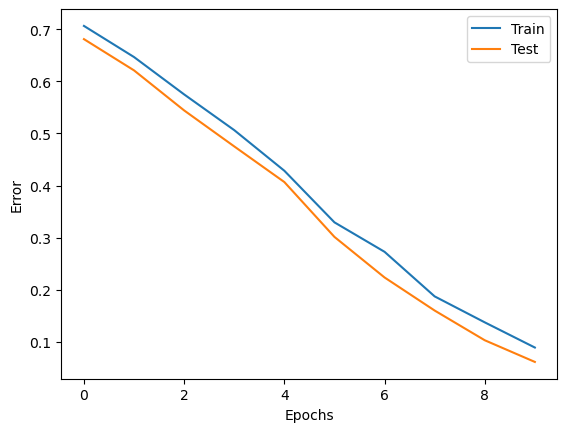

In [24]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss_)), train_loss_, label="Train")
plt.plot(range(len(test_loss_)), test_loss_, label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()  # ラベルがあるときは、きちんとplt.show()を呼び出すこと